In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import scipy.sparse as sp
import math

from kuramoto import *
from wilson_cowan import *

import networkx as nx

from itertools import product

import pickle

from scipy.optimize import curve_fit
import scipy.stats

# change to point to your installation
import sys
sys.path.append('../ConfigModel_MCMC/configuration_model_mcmc')
import configuration_model_mcmc as CM

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

# Ring

Presently, the implementation has a divide by zero error when the variance of the degree sequence is zero. I've submitted an issue on Github.

# Cartesian Lattice

In [3]:
def get_network_statistics(edge_list, G=None):
    if G is None:
        G = nx.convert.from_edgelist(edge_list)
    clustering_coeff = nx.transitivity(G)
    mean_path_length = nx.average_shortest_path_length(G)
    diameter = nx.networkx.algorithms.distance_measures.diameter(G)
    return clustering_coeff, mean_path_length, diameter

In [4]:
base_trials = 50
null_trials = 500
t0 = 0
t_final = 50
time_span = (t_final/2, t_final)
n = 7
coupling_coefficient = 0.45
variance = 0.01
N = n**2

wcn, edge_list, x_locations, y_locations = perc_network(n, coupling_weight=coupling_coefficient, random_edges=0)
θE = -2
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)
wcn.E0 = np.random.random(N)*.5
wcn.I0 = np.random.random(N)*.5
wcn.excitatory_variance = variance
wcn.inhibitory_variance = 0

base_stats = get_network_statistics(edge_list)
results = []
for trial in range(base_trials):
    print(f'Perc Model - trial {trial+1}/{base_trials}' + ' '*100, end='\r')
    ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
    kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
    pearson = pearson_mean(ts, Es, time_span=time_span)
    results.append((kuramoto, pearson))
    
null_model_results = []

G = nx.convert.from_edgelist(edge_list)
mcmc_object = CM.MCMC(G)
G2 = mcmc_object.get_graph()
for trial in range(null_trials):
    print(f'Null Model - trial {trial+1}/{null_trials}' + ' '*100, end='\r')
    G_null = mcmc_object.get_graph()
    clustering_coeff, mean_path_length, diameter = get_network_statistics(None, G=G_null)
    EE_mat = nx.convert_matrix.to_scipy_sparse_matrix(G_null) + sp.eye(N)*wcn.EE_mat[0,0]
    wcn.EE_mat = EE_mat
    ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
    kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
    pearson = pearson_mean(ts, Es, time_span=time_span)
    null_model_results.append((kuramoto, pearson, clustering_coeff, mean_path_length, diameter))
    
with open(f'raw_data/fosdick_MCMC_perc.pickle', 'wb') as f:
        pickle.dump((base_stats, results, null_model_results), f)

In [59]:
# with open(f'raw_data/fosdick_MCMC_perc.pickle', 'rb') as f:
#     base_stats, results, null_model_results = pickle.load(f)

In [55]:
def bins_and_averages(xs, ys, n=20):
    xs = np.array(xs)
    ys = np.array(ys)
    lower, upper = np.min(xs), np.max(xs)
    bin_boundaries = np.linspace(lower, upper, n+1)
    bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1])/2
    means = []
    Q1s = []
    Q3s = []
    for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        mask = np.logical_and(xs >= lower, xs <=upper)
        data = ys[mask]
        means.append(np.mean(data))
        Q1s.append(np.quantile(data, .25))
        Q3s.append(np.quantile(data, .75))
    return bin_centers, means, Q1s, Q3s

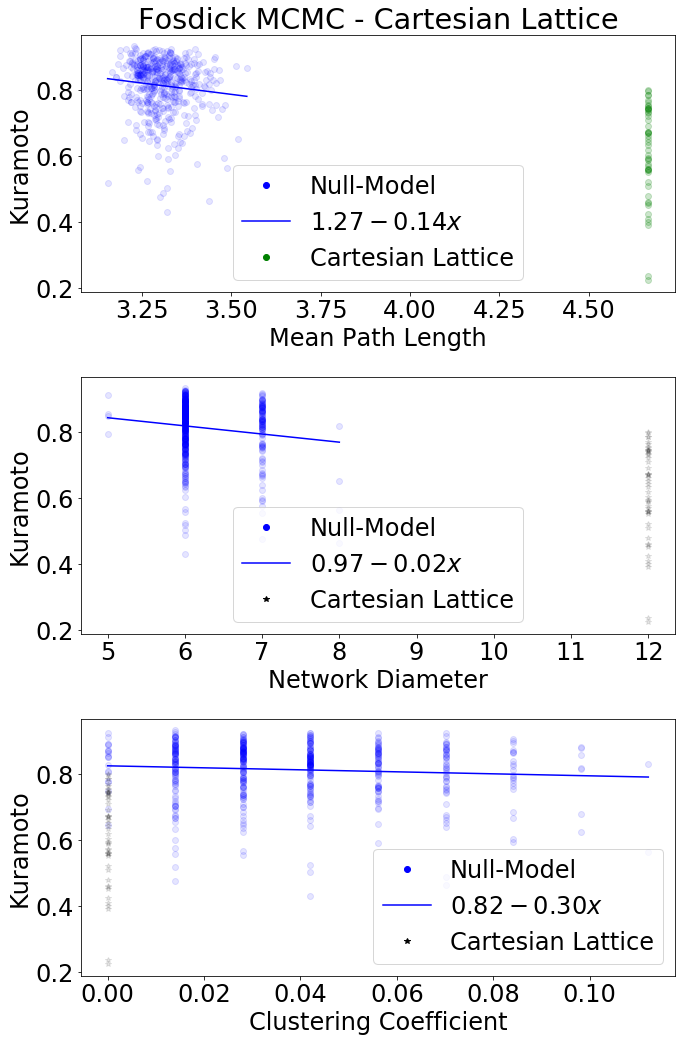

In [62]:
null_results_array = np.array(null_model_results).T
null_kuramoto, null_pearson, null_clustering_coeff, null_mean_path_length, null_diameter = null_results_array

base_clustering_coefficient, base_mean_path_length, base_diameter = base_stats
results_kuramoto, results_pearson = np.array(results).T

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

alpha = 0.1

statistic = null_mean_path_length
linear_regression = scipy.stats.linregress(statistic, null_kuramoto)
slope = linear_regression.slope
intercept = linear_regression.intercept
xs = np.linspace(np.min(statistic), np.max(statistic))
axes[0].plot(null_mean_path_length, null_kuramoto, 'bo', alpha=alpha)
axes[0].plot([], [], 'bo', label='Null-Model')
axes[0].plot(xs, intercept + xs*slope, 'b-', label=f'${intercept:.2f}{slope:+.2f}x$')
axes[0].plot([base_mean_path_length]*len(results_kuramoto), results_kuramoto, 'go', alpha=alpha*2)
axes[0].plot([], [], 'go', label='Cartesian Lattice')
axes[0].set_xlabel('Mean Path Length')
axes[0].set_ylabel('Kuramoto')
axes[0].legend()

statistic = null_diameter
linear_regression = scipy.stats.linregress(statistic, null_kuramoto)
slope = linear_regression.slope
intercept = linear_regression.intercept
xs = np.linspace(np.min(statistic), np.max(statistic))
axes[1].plot(null_diameter, null_kuramoto, 'bo', alpha=alpha)
axes[1].plot([], [], 'bo', label='Null-Model')
axes[1].plot(xs, intercept + xs*slope, 'b-', label=f'${intercept:.2f}{slope:+.2f}x$')
axes[1].plot([base_diameter]*len(results_kuramoto), results_kuramoto, 'k*', alpha=alpha)
axes[1].plot([], [], 'k*', label='Cartesian Lattice')
axes[1].set_ylabel('Kuramoto')
axes[1].set_xlabel('Network Diameter')
axes[1].legend()

statistic = null_clustering_coeff
linear_regression = scipy.stats.linregress(statistic, null_kuramoto)
slope = linear_regression.slope
intercept = linear_regression.intercept
xs = np.linspace(np.min(statistic), np.max(statistic))
axes[2].plot(null_clustering_coeff, null_kuramoto, 'bo', alpha=alpha)
axes[2].plot([], [], 'bo', label='Null-Model', alpha=1)
axes[2].plot(xs, intercept + xs*slope, 'b-', label=f'${intercept:.2f}{slope:+.2f}x$')
axes[2].plot([base_clustering_coefficient]*len(results_kuramoto), results_kuramoto, 'k*', alpha=alpha)
axes[2].plot([], [], 'k*', label='Cartesian Lattice')
axes[2].set_ylabel('Kuramoto')
axes[2].set_xlabel('Clustering Coefficient')
# plt.ylabel('Synchrony')

axes[0].set_title('Fosdick MCMC - Cartesian Lattice')

plt.legend()

plt.tight_layout()

# plt.savefig('images/fosdick_perc.png')

plt.show()

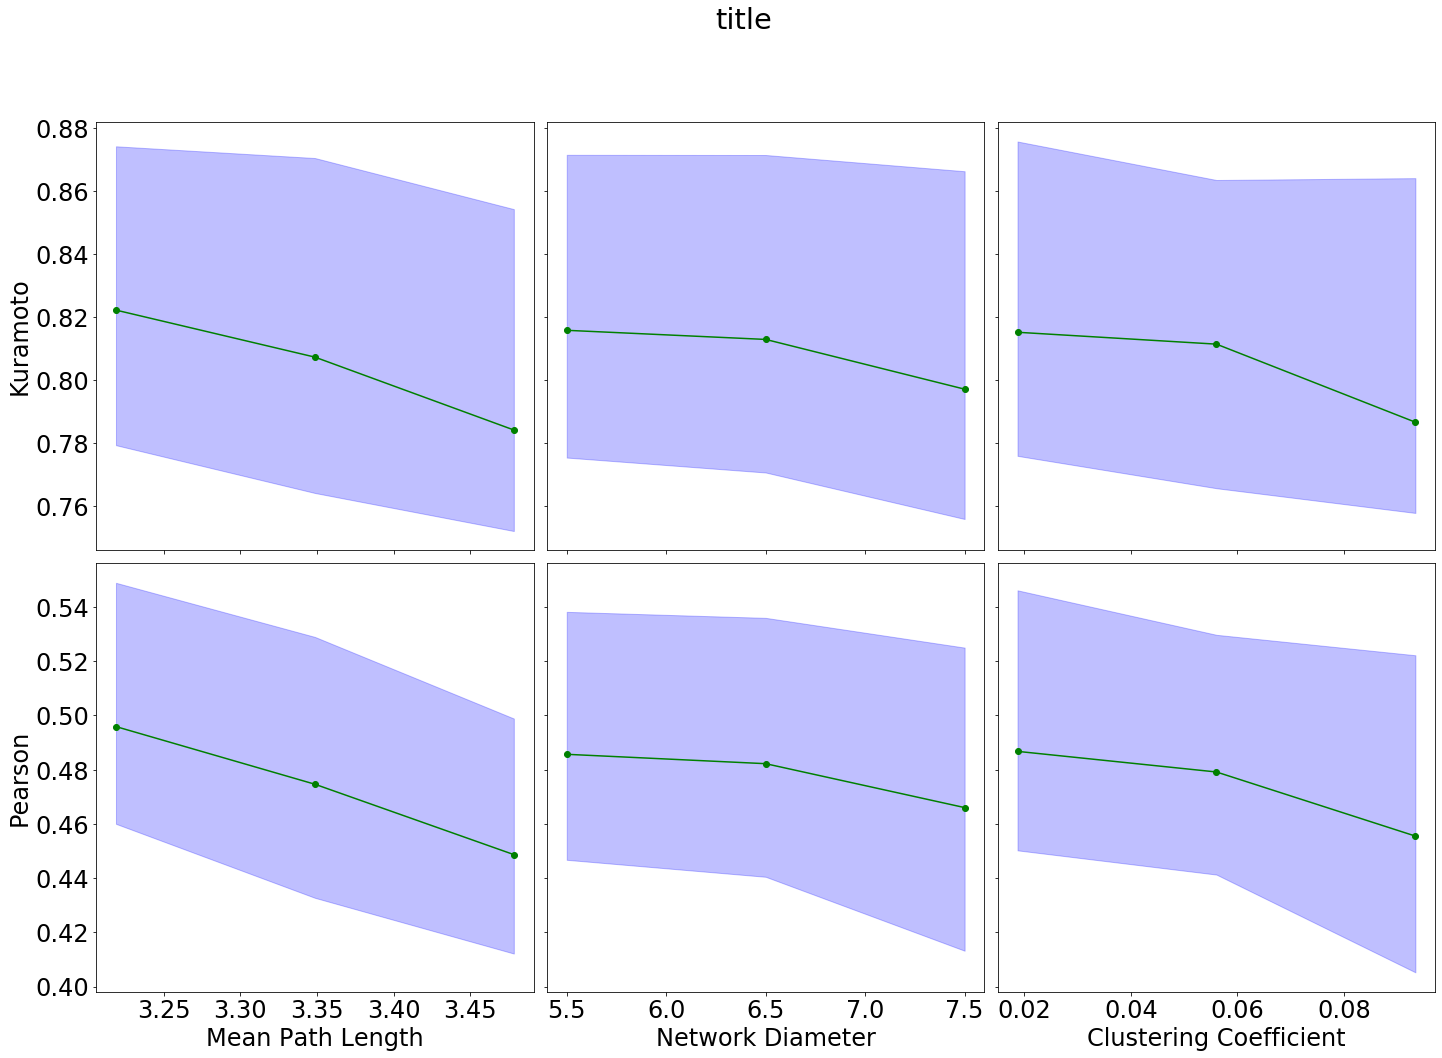

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharey='row', sharex='col')
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for row, y_var in enumerate([null_kuramoto, null_pearson]):
    for col, x_var in enumerate([null_mean_path_length, null_diameter, null_clustering_coeff]):
        bin_centers, means, Q1s, Q3s = bins_and_averages(x_var, y_var, n=3)
        axes[row][col].plot(bin_centers, means, 'go-', label='Mean')
        axes[row][col].fill_between(bin_centers, Q1s, Q3s, alpha=.25, label='IQR', color='b')
        
for col, label in enumerate(['Mean Path Length', 'Network Diameter', 'Clustering Coefficient']):
    axes[-1][col].set_xlabel(label)
    
for row, label in enumerate(['Kuramoto', 'Pearson']):
    axes[row][0].set_ylabel(label)
    
plt.suptitle('title')

# plt.tight_layout()

# plt.savefig('images/summary_stats_hex.png')
        
plt.show()

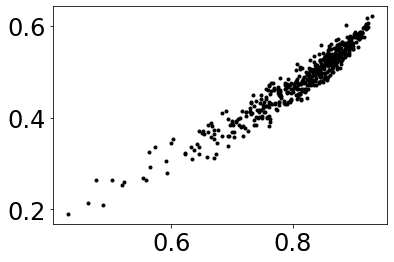

In [11]:
plt.plot(null_kuramoto, null_pearson, 'k.')

# Hex Model

In [47]:
total_nodes = lambda hex_radius: 1 + 3*hex_radius + 3*hex_radius**2
total_edges = lambda hex_radius: 9*hex_radius*(hex_radius+1) - 6*hex_radius

In [49]:
base_trials = 50
null_trials = 500
t0 = 0
t_final = 50
time_span = (t_final/2, t_final)
n = 4
N = total_nodes(n)
coupling_coefficient = 0.3
variance = 0.01

wcn, edge_list, x_locations, y_locations = hex_network(n, coupling_weight=coupling_coefficient, random_edges=0)
θE = -2
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)
wcn.E0 = np.random.random(N)*.5
wcn.I0 = np.random.random(N)*.5
wcn.excitatory_variance = variance
wcn.inhibitory_variance = 0

base_stats = get_network_statistics(edge_list)
results = []
for trial in range(base_trials):
    print(f'Hex Model - trial {trial+1}/{base_trials}' + ' '*100, end='\r')
    ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
    kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
    pearson = pearson_mean(ts, Es, time_span=time_span)
    results.append((kuramoto, pearson))
    
null_model_results = []

G = nx.convert.from_edgelist(edge_list)
mcmc_object = CM.MCMC(G)
G2 = mcmc_object.get_graph()
for trial in range(null_trials):
    print(f'Null Model - trial {trial+1}/{null_trials}' + ' '*100, end='\r')
    G_null = mcmc_object.get_graph()
    clustering_coeff, mean_path_length, diameter = get_network_statistics(None, G=G_null)
    EE_mat = nx.convert_matrix.to_scipy_sparse_matrix(G_null) + sp.eye(N)*wcn.EE_mat[0,0]
    wcn.EE_mat = EE_mat
    ts, Es, Is = wcn.simulate(t_final, Δt = 1e-3)
    kuramoto = average_kuramoto(ts, Es.T, time_span=time_span)
    pearson = pearson_mean(ts, Es, time_span=time_span)
    null_model_results.append((kuramoto, pearson, clustering_coeff, mean_path_length, diameter))
    
with open(f'raw_data/fosdick_MCMC_hex.pickle', 'wb') as f:
        pickle.dump((base_stats, results, null_model_results), f)

In [ ]:
# with open(f'raw_data/fosdick_MCMC_hex.pickle', 'rb') as f:
#     base_stats, results, null_model_results = pickle.load(f)

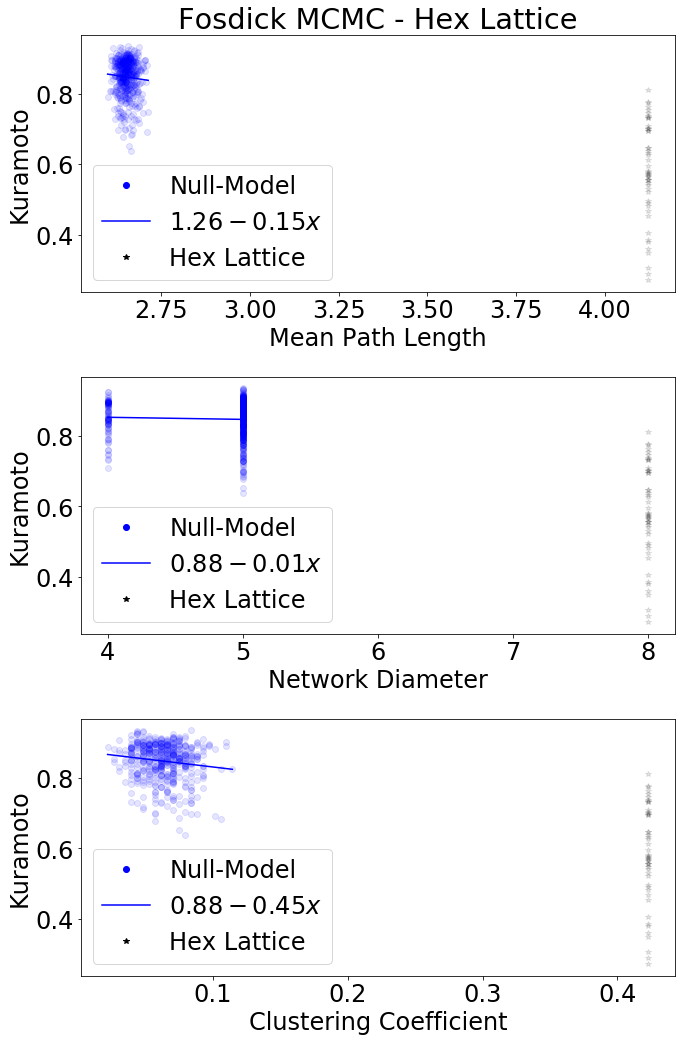

In [53]:
null_results_array = np.array(null_model_results).T
null_kuramoto, null_pearson, null_clustering_coeff, null_mean_path_length, null_diameter = null_results_array

base_clustering_coefficient, base_mean_path_length, base_diameter = base_stats
results_kuramoto, results_pearson = np.array(results).T

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

alpha = 0.1

statistic = null_mean_path_length
linear_regression = scipy.stats.linregress(statistic, null_kuramoto)
slope = linear_regression.slope
intercept = linear_regression.intercept
xs = np.linspace(np.min(statistic), np.max(statistic))
axes[0].plot(null_mean_path_length, null_kuramoto, 'bo', alpha=alpha)
axes[0].plot([], [], 'bo', label='Null-Model')
axes[0].plot(xs, intercept + xs*slope, 'b-', label=f'${intercept:.2f}{slope:+.2f}x$')
axes[0].plot([base_mean_path_length]*len(results_kuramoto), results_kuramoto, 'k*', alpha=alpha)
axes[0].plot([], [], 'k*', label='Hex Lattice')
axes[0].set_xlabel('Mean Path Length')
axes[0].set_ylabel('Kuramoto')
axes[0].legend()

statistic = null_diameter
linear_regression = scipy.stats.linregress(statistic, null_kuramoto)
slope = linear_regression.slope
intercept = linear_regression.intercept
xs = np.linspace(np.min(statistic), np.max(statistic))
axes[1].plot(null_diameter, null_kuramoto, 'bo', alpha=alpha)
axes[1].plot([], [], 'bo', label='Null-Model')
axes[1].plot(xs, intercept + xs*slope, 'b-', label=f'${intercept:.2f}{slope:+.2f}x$')
axes[1].plot([base_diameter]*len(results_kuramoto), results_kuramoto, 'k*', alpha=alpha)
axes[1].plot([], [], 'k*', label='Hex Lattice')
axes[1].set_ylabel('Kuramoto')
axes[1].set_xlabel('Network Diameter')
axes[1].legend()

statistic = null_clustering_coeff
linear_regression = scipy.stats.linregress(statistic, null_kuramoto)
slope = linear_regression.slope
intercept = linear_regression.intercept
xs = np.linspace(np.min(statistic), np.max(statistic))
axes[2].plot(null_clustering_coeff, null_kuramoto, 'bo', alpha=alpha)
axes[2].plot([], [], 'bo', label='Null-Model', alpha=1)
axes[2].plot(xs, intercept + xs*slope, 'b-', label=f'${intercept:.2f}{slope:+.2f}x$')
axes[2].plot([base_clustering_coefficient]*len(results_kuramoto), results_kuramoto, 'k*', alpha=alpha)
axes[2].plot([], [], 'k*', label='Hex Lattice')
axes[2].set_ylabel('Kuramoto')
axes[2].set_xlabel('Clustering Coefficient')
# plt.ylabel('Synchrony')

axes[0].set_title('Fosdick MCMC - Hex Lattice')

plt.legend()

plt.tight_layout()

# plt.savefig('images/fosdick_hex.png')

plt.show()